# Scrapbook

This notebook is used for development, its content can change at any time.

In [1]:
import timeatlas as ta
import pandas as pd
import numpy as np

In [ ]:
s = pd.read_csv("../data/bbdata/2902.csv")
s = pd.DataFrame(data=s["value"].values, index=pd.to_datetime(s["timestamp"]).values)
s.index = s.index.round("S")

In [2]:
s = pd.read_csv("../data/bbdata/2902.csv")
s = pd.DataFrame(data=s["value"].values, index=pd.to_datetime(s["timestamp"]).values)
s.index = s.index.round("S")

In [3]:
ts = ta.TimeSeries(s)

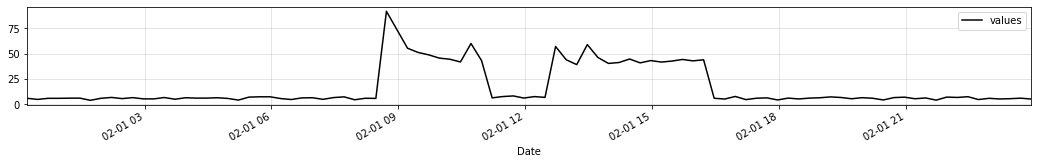

In [4]:
ts.plot()

## Define a Metadata object

In [5]:
from timeatlas import Metadata, types

# You can use some typed metadata object
my_unit = types.Unit("power", "W", "float")
my_sensor = types.Sensor(2902, "HB/floor2/22-23C/Prises_Power_Tot")

# Or use Python dictionaries
my_location = {
    "building" : "Blue Factory",
    "floor" : "12",
    "room"  : "22C"
}
my_coordinates = {
    "lat" : 46.796611,
    "lon" : 7.147563
}
my_dict = {
    "unit": my_unit,
    "sensor": my_sensor,
    "location": my_location,
    "coordinates": my_coordinates
}

# Create the Metadata object
my_meta = Metadata(my_dict)


## Define a TimeSeries with Metadata

In [6]:
ts = ts.fill(np.random.randint(0,100,len(ts)))

In [7]:
ts.metadata = my_meta

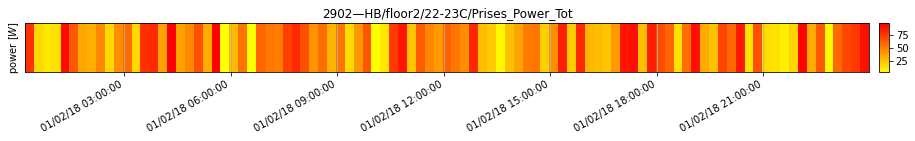

<AxesSubplot:title={'center':'2902—HB/floor2/22-23C/Prises_Power_Tot'}, ylabel='power $[W]$'>

In [8]:
ta.plots.status(ts)

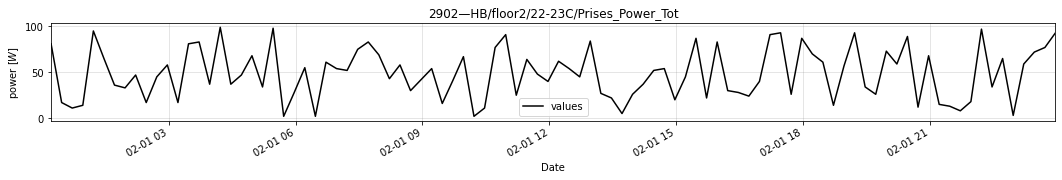

In [9]:
ts.plot()

## Make Predictions

Some definitions:

- `time series` : self-explanatory, i.e. the TimeSeries object
- `horizon` : the duration to predict after the last value of the time series
- `frequency`: the number of values per unit of time. Usually, the frequency is given in Pandas offset aliases (https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

```
                                horizon
   |-------------------------|- - - - - -|
                             |||||||||||||
           time series         frequency

```

In [10]:
from timeatlas import models

### Train a Facebook Prophet model

In [11]:
m1 = models.Prophet()
m1.fit(ts)
pts1 = m1.predict(ts)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


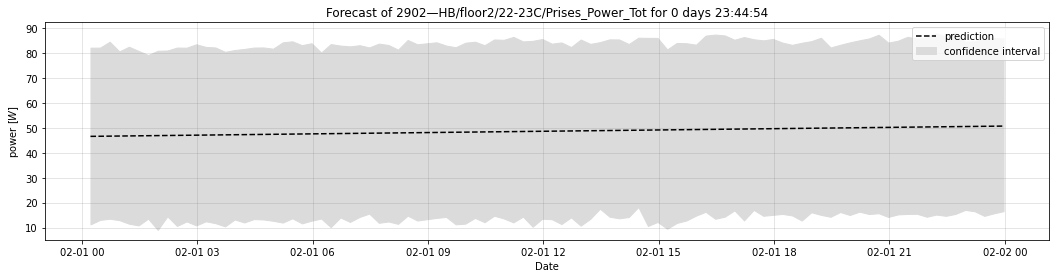

In [12]:
pts1 = m1.predict(ts).plot()

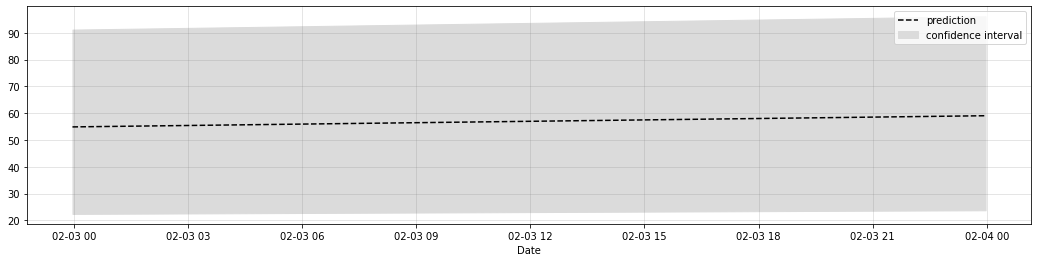

In [13]:
pts2 = m1.predict("2 days").plot()

### Train a Linear Regressor

In [14]:
m2 = models.LinearRegression()
m2.fit(ts)


In [15]:
def __prepare_series_for_sklearn(ts):
    """
    Prepare a TimeSeries object for Scikit Learn

    Args:
        ts: the TimeSeries to prepare

    Returns:
        a Tuple made with two elements:
            - a Numpy ndarray with shape (x, 1)
            - a Numpy ndarray with shape (x,)
    """
    X_train = ts.series.index.factorize()[0].reshape(-1, 1)
    y_train = ts.series["values"].to_numpy()
    return X_train, y_train

a = __prepare_series_for_sklearn(ts)

a[1].shape


(95,)

In [20]:
pts3 = m2.predict(ts)

In [21]:
pts4 = m2.predict("14 days")

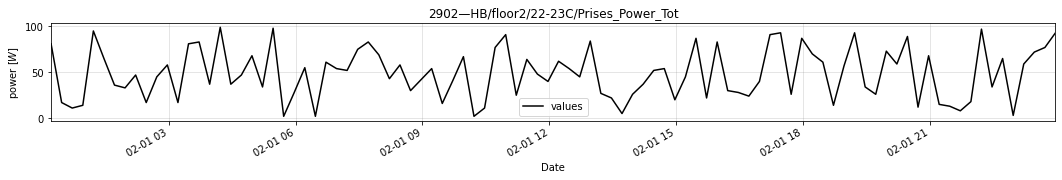

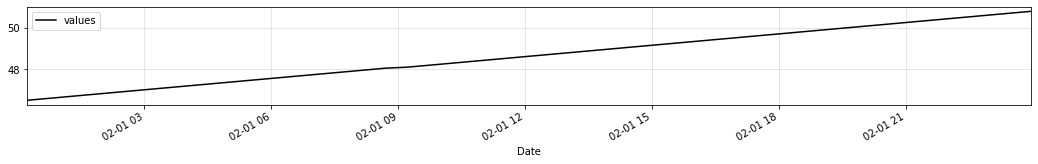

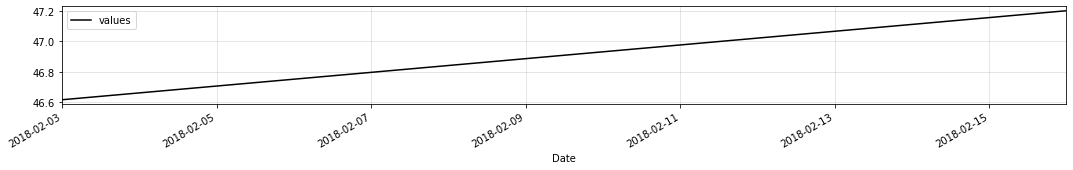

In [22]:
ts.plot()
pts3.plot()
pts4.plot()

KeyError: 'ci_lower'

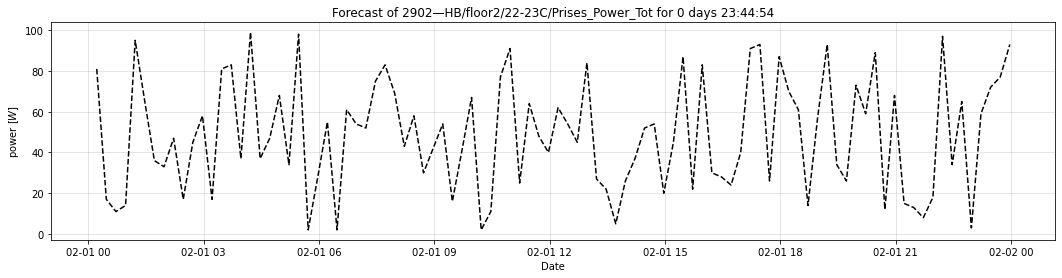

In [23]:
from timeatlas import plots

plots.prediction(ts, pts3)

## Detect Anomalies


In [ ]:
from timeatlas import detectors, metrics

In [ ]:
ts.apply(lambda x: x+1).series.head()

In [ ]:
# Create the base of the detector. 
# i.e. this detector is based on this model and compute this error
d = detectors.Surprise(m1, metrics.relative_error)

# Set the alerts
d.alerts("quantile", [0.65, 0.8, 0.85, 0.95])\

# Fit the detector with a specific Time Series
d.fit(ts)

In [ ]:
# Detect anomalies with the fitted detector
a = d.detect(ts)

In [ ]:
a.plot()

In [ ]:
d.truth.plot()
d.prediction.plot()